# Kaggle's Nature Conservancy Fisheries Challenge

This notebook explores the images and trains models for the [Nature Conservancy Fisheries Competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring) hosted on Kaggle. This notebook assumes a file containing one's own annotations in `data/markers.csv`.

We start with some exploration and preparation of the dataset.

## Data Preparation

### Setup

import libraries

In [1]:
%matplotlib inline

# system libraries
from glob import glob
import logging

# numerical,image and plotting stuff
import pandas as pd
import numpy as np
from PIL import Image
from skimage import io
import skimage.transform as tf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False})

### Files

The directory structure of this project places images in their labelled folders, which facilitates easy 're-labeling' just by moving files around. During the annotation phase, some 'mis-labeled' pictures were discovered and have been manually moved into different folders.

Let's begin by getting all the image file names and their associated classes from their latest location.

In [2]:
# get all image file names and associated class from their latest location
class_folders = glob('data/train/*')
files = [glob(cls + '/*') for cls in class_folders] # put class info with file name
files = [img for cls in files for img in cls]
df = pd.DataFrame({'fpath':files,'w':0,'h':0})
df['category'] = df.fpath.str.extract('data/train/([a-zA-Z]*)/img', expand=False) # extract class
df['fname'] = df.fpath.str.extract('data/train/[a-zA-Z]*/([a-zA-Z0-9_.]*)', expand=False) # extract file name
df.head()

fpath  h  w category          fname
0  data/train/ALB/img_00003.jpg  0  0      ALB  img_00003.jpg
1  data/train/ALB/img_00010.jpg  0  0      ALB  img_00010.jpg
2  data/train/ALB/img_00012.jpg  0  0      ALB  img_00012.jpg
3  data/train/ALB/img_00015.jpg  0  0      ALB  img_00015.jpg
4  data/train/ALB/img_00019.jpg  0  0      ALB  img_00019.jpg

### Dimensions

To get a feel for how large the pictures, we get the width and height of each picture, and plot their bi-variate distribution.

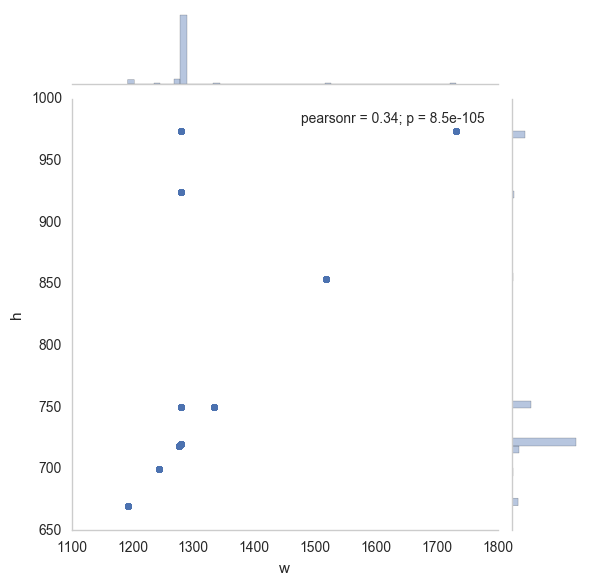

In [3]:
# get a distribution of w,h of all images ~4s for PIL's Image.open, 
# much longer for skimage.io.imread
for idx in df.index:
    im = Image.open(df.ix[idx].fpath)
    df.ix[idx,['w','h']] = im.size

df.to_csv('data/train.csv',index=False)
sns.jointplot(data=df,x='w',y='h',kind='scatter')

Height and width are approximately 720 x 1280. If we were to read all the files into memory, that would take up 3777 images \* 720 \* 1280 \* 3 = 10.4GB, which is not too much for modern computers. But to be memory-friendly and make this code accessible to others without the luxury of >= 16GB RAM, we'll write a generator to read in the files. Moreover, we would need a generator to perform various augmentations to our dataset to avoid over-fitting.

### Images

Let's see how the images look like with the following cell. If we re-run the following cell, we'll realize slowly that some of the pictures for the same class seem very similar, and could have been taken around the same time from the same camera from the same boat.

                                        fpath    h     w category  \
category                                                            
ALB      427     data/train/ALB/img_01928.jpg  720  1280      ALB   
BET      1874    data/train/BET/img_05736.jpg  720  1280      BET   
DOL      2032    data/train/DOL/img_07557.jpg  720  1280      DOL   
LAG      2091    data/train/LAG/img_06257.jpg  720  1280      LAG   
NoF      2549    data/train/NoF/img_07500.jpg  720  1280      NoF   
OTHER    2606  data/train/OTHER/img_00821.jpg  720  1280    OTHER   
SHARK    3022  data/train/SHARK/img_06881.jpg  974  1280    SHARK   
YFT      3713    data/train/YFT/img_07338.jpg  974  1280      YFT   

                       fname  
category                      
ALB      427   img_01928.jpg  
BET      1874  img_05736.jpg  
DOL      2032  img_07557.jpg  
LAG      2091  img_06257.jpg  
NoF      2549  img_07500.jpg  
OTHER    2606  img_00821.jpg  
SHARK    3022  img_06881.jpg  
YFT      3713  img_07338.jpg  

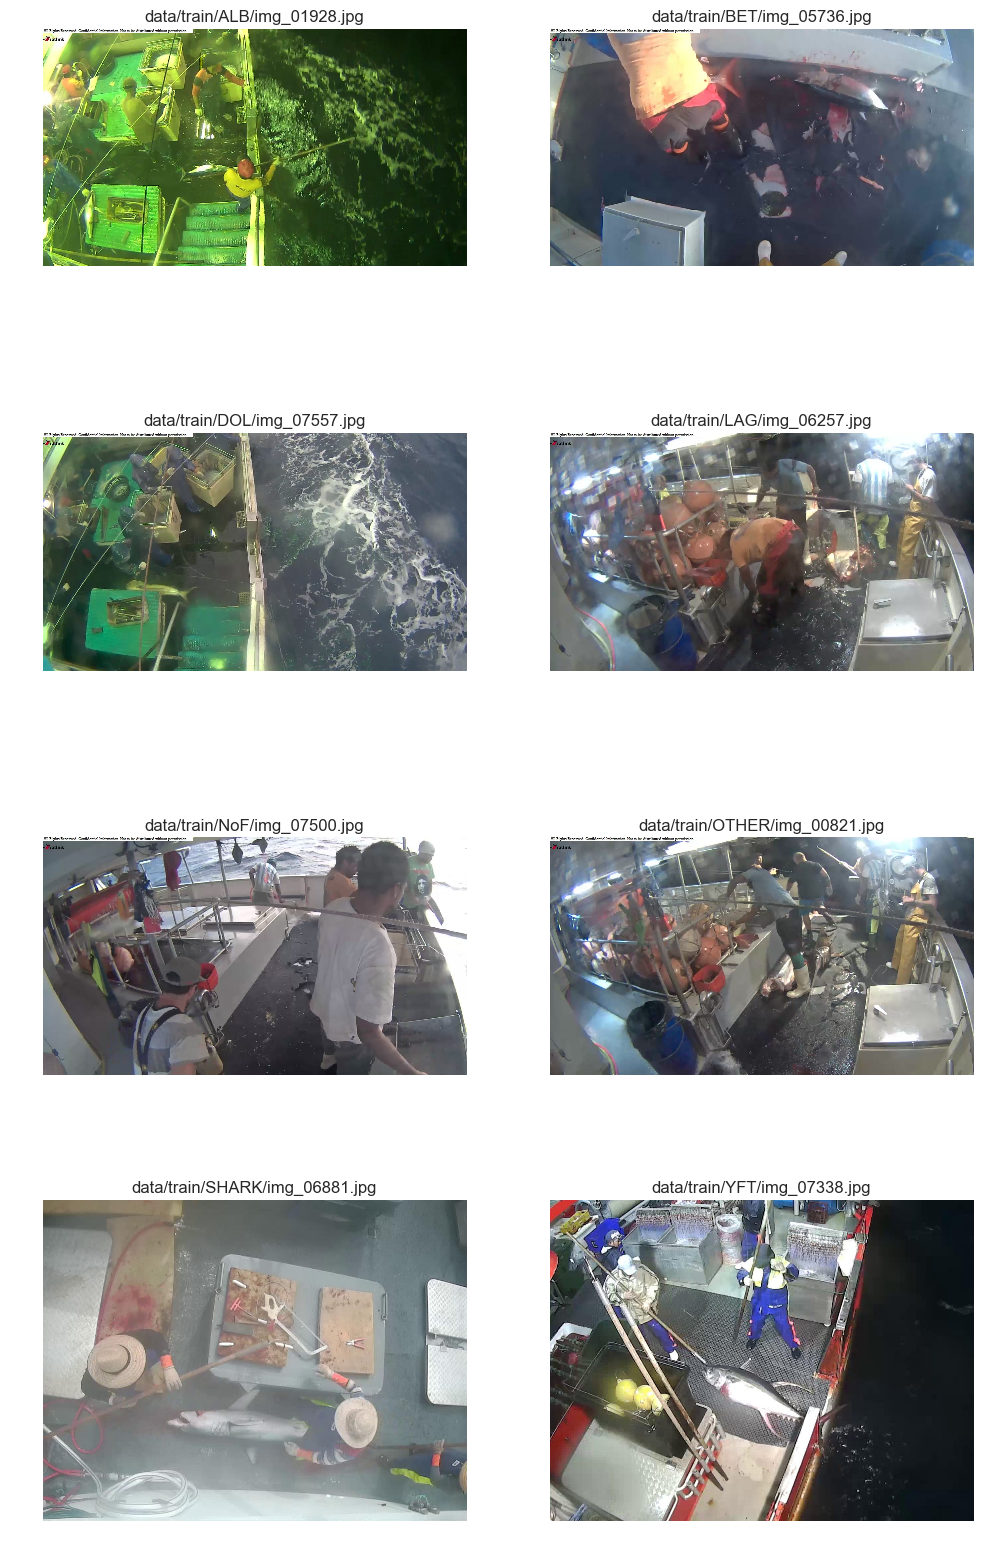

In [4]:
# sample an image per class of fish
fishes = df.groupby('category').apply(lambda x: x.sample(1))
print(fishes)
f = plt.figure(figsize=(12,20))
for i in range(len(fishes)):
    fpath = fishes.iloc[i]['fpath']
    img = io.imread(fpath)
    ax = plt.subplot(4,2,i+1)
    ax.imshow(img)
    ax.set_title(fpath)
    ax.axis('off')


### Annotations (Nathaniel's)

We read in all the annotations from [nathaniel's repository](https://github.com/nathanie/kaggleNatureConservancy) into a dataframe named `markers1`. The annotated json files should be in a folder titled `kaggleNatureConservancy` in the data folder.

As some of the annotations are just empty lists `[]` or lists of empty dictionaries `[{}]`, we perform some error handling to return `np.NaN` instead. We print out a list of the files without annotations as a simple sanity check.

In [5]:
f_json = glob('data/kaggleNatureConservancy/*.json')
markers1 = pd.DataFrame(columns=['annotations','class','filename'])
for i_json in f_json:
    print('reading %s' % i_json)
    i_markers = pd.read_json(i_json)
    markers1 = markers1.append(i_markers)

def split_annotations(an, default = (np.nan,np.nan,np.nan,np.nan)):
    try:
        return round(an[0]['x'],1), round(an[0]['y'],1), round(an[1]['x'],1), round(an[1]['y'],1)
    except KeyError:
        return default
    except IndexError:
        return default
    except Exception as e:
        print(e)
        return default

markers1['head_x'], markers1['head_y'], markers1['tail_x'], markers1['tail_y'] = \
    zip(* markers1['annotations'].map(split_annotations))
markers1 = markers1[['filename','head_x','head_y','tail_x','tail_y']]
print('\nfiles with missing labels:')
print(markers1[markers1['head_x'].isnull()])

reading data/kaggleNatureConservancy/alb_labels.json
reading data/kaggleNatureConservancy/bet_labels.json
reading data/kaggleNatureConservancy/dol_labels.json
reading data/kaggleNatureConservancy/lag_labels.json
reading data/kaggleNatureConservancy/other_labels.json
reading data/kaggleNatureConservancy/shark_labels.json
reading data/kaggleNatureConservancy/yft_labels.json

files with missing labels:
            filename  head_x  head_y  tail_x  tail_y
314    img_01445.jpg     NaN     NaN     NaN     NaN
360    img_01660.jpg     NaN     NaN     NaN     NaN
699    img_03213.jpg     NaN     NaN     NaN     NaN
816    img_03694.jpg     NaN     NaN     NaN     NaN
901    img_04100.jpg     NaN     NaN     NaN     NaN
1362   img_06460.jpg     NaN     NaN     NaN     NaN
0     image00107.jpg     NaN     NaN     NaN     NaN
9      img_00379.jpg     NaN     NaN     NaN     NaN
0           temp.jpg     NaN     NaN     NaN     NaN
0         image2.jpg     NaN     NaN     NaN     NaN
0         imag

### Annotations (ours)

We read in our own annotations that is contained in `markers.csv`, then append it to the first set of annotations into a dataframe `markers`.

In [6]:
# read annotations 
markers2 = pd.read_csv('data/markers.csv')
markers2.head() 
# note the multiple annotations for the same image

filename  head_x  head_y  tail_x  tail_y
0  img_00020.jpg   719.9   656.5   817.0   498.7
1  img_00020.jpg   748.9   507.0   794.9   397.4
2  img_00020.jpg   639.8   719.6   694.3   550.2
3  img_00020.jpg   656.9   423.9   726.7   352.5
4  img_00020.jpg   627.9   477.1   762.5   400.7

In [7]:
# combine annotations into a single data frame
markers = markers1.append(markers2)
markers = markers.sort_values(by=['filename','head_x','head_y','tail_x','tail_y'])
markers = markers.dropna()
markers.head(10)

filename  head_x  head_y  tail_x  tail_y
1224  img_00003.jpg   314.4   377.4   595.5   191.4
1225  img_00003.jpg   384.2   126.6   711.4   136.6
1226  img_00003.jpg   675.6   108.4   982.3   171.5
0     img_00003.jpg   825.5   342.8  1095.1   449.4
1227  img_00003.jpg   827.2   339.2  1096.4   448.9
1     img_00004.jpg   560.2   487.4   892.0   665.0
1228  img_00010.jpg   718.2   600.0   689.2   438.9
1     img_00010.jpg   721.6   606.1   688.1   433.6
1229  img_00010.jpg   846.0   407.3   910.7   319.3
2     img_00012.jpg   492.2   514.0   602.7   681.4

As there are 'overlapping' annotations which are present in both datasets, but not exactly the same, we would need a simple function for de-duplicating them in each image. If the head and tail coords differ by less than a threshold (20px), we keep the first (nathaniel's) annotation. 

To prevent having to build a full cartesian product of all pairs of entries, we sort by the `filename` and the respective coordinate columns. Our task is then reduced to comparing adjacent records, which we achieve by adding a 1-shifted column that contains the previous row's coords :)

In [8]:
# add 1-shifted column of coordinates
markers['prev_head_x'] = markers.groupby('filename')['head_x'].shift()
markers['prev_tail_x'] = markers.groupby('filename')['tail_x'].shift()
markers['prev_head_y'] = markers.groupby('filename')['head_y'].shift()
markers['prev_tail_y'] = markers.groupby('filename')['tail_y'].shift()

def is_repeated(row,threshold=20):
    # if prev_head_x is na, it would be first coord in markers
    if np.isnan(row['prev_head_x']):
        return False
    else:
        diff_head_x = abs(row['head_x'] - row['prev_head_x'])
        diff_head_y = abs(row['head_y'] - row['prev_head_y'])
        diff_tail_x = abs(row['tail_x'] - row['prev_tail_x'])
        diff_tail_y = abs(row['tail_y'] - row['prev_tail_y'])
        if_similar = diff_head_x <= threshold and diff_head_y <= threshold and \
            diff_tail_x <= threshold and diff_tail_y <= threshold
        return if_similar

# see results
markers['is_repeated'] = markers.apply(is_repeated,axis=1)
markers

filename       head_x      head_y       tail_x      tail_y  \
1224  img_00003.jpg   314.400000  377.400000   595.500000  191.400000   
1225  img_00003.jpg   384.200000  126.600000   711.400000  136.600000   
1226  img_00003.jpg   675.600000  108.400000   982.300000  171.500000   
0     img_00003.jpg   825.500000  342.800000  1095.100000  449.400000   
1227  img_00003.jpg   827.200000  339.200000  1096.400000  448.900000   
1     img_00004.jpg   560.200000  487.400000   892.000000  665.000000   
1228  img_00010.jpg   718.200000  600.000000   689.200000  438.900000   
1     img_00010.jpg   721.600000  606.100000   688.100000  433.600000   
1229  img_00010.jpg   846.000000  407.300000   910.700000  319.300000   
2     img_00012.jpg   492.200000  514.000000   602.700000  681.400000   
1230  img_00012.jpg   495.000000  521.700000   609.100000  697.000000   
2     img_00014.jpg   381.700000  345.800000   553.100000  471.800000   
3     img_00015.jpg   258.000000  359.600000   435.700000  396.200000   
1231  img_00015.jpg   259.900000  363.700000   450.700000  401.800000   
4     img_00019.jpg   165.000000  459.300000   284.300000  415.500000   
1232  img_00019.jpg   171.300000  457.200000   280.300000  419.000000   
123   img_00020.jpg   615.965006  477.097593   755.678152  395.711810   
4     img_00020.jpg   627.900000  477.100000   762.500000  400.700000   
120   img_00020.jpg   636.410833  716.272140   701.155949  528.586558   
2     img_00020.jpg   639.800000  719.600000   694.300000  550.200000   
124   img_00020.jpg   656.856659  423.947694   728.417050  350.866582   
3     img_00020.jpg   656.900000  423.900000   726.700000  352.500000   
5     img_00020.jpg   712.900000  675.200000   800.300000  491.000000   
121   img_00020.jpg   714.786499  676.409716   823.830905  487.063199   
0     img_00020.jpg   719.900000  656.500000   817.000000  498.700000   
122   img_00020.jpg   742.047601  513.638149   776.123978  389.068072   
1     img_00020.jpg   748.900000  507.000000   794.900000  397.400000   
125   img_00020.jpg   803.385079  460.488250   837.461456  347.544714   
3     img_00021.jpg   891.100000  620.400000   885.500000  414.500000   
4     img_00023.jpg   235.500000  428.600000   461.100000  442.700000   
...             ...          ...         ...          ...         ...   
212   img_07864.jpg   341.600000  428.600000   678.100000  438.700000   
1700  img_07868.jpg   787.300000  179.300000  1037.800000  368.100000   
1701  img_07869.jpg   584.200000  381.200000   501.100000  311.100000   
1702  img_07871.jpg   624.600000  616.200000   778.300000  462.500000   
1703  img_07874.jpg   427.200000  397.600000   569.600000  424.400000   
1704  img_07876.jpg   714.900000  597.800000   688.100000  431.500000   
1705  img_07877.jpg   609.100000   98.700000   925.000000  210.100000   
1706  img_07878.jpg  1085.700000  540.000000  1064.600000  772.700000   
1707  img_07879.jpg   550.000000  435.000000   425.000000  417.000000   
1708  img_07883.jpg   608.000000  501.100000   593.700000  384.700000   
1709  img_07885.jpg   776.000000  157.000000   950.000000   85.000000   
1710  img_07890.jpg   712.000000  600.000000   687.000000  431.000000   
732   img_07891.jpg  1146.300000  633.100000   423.000000  706.400000   
1711  img_07892.jpg   271.000000  166.000000   574.000000  102.000000   
117   img_07898.jpg   387.800000  459.700000   596.400000  456.800000   
733   img_07901.jpg   108.600000  393.400000   382.100000  427.200000   
1712  img_07903.jpg   647.000000  472.000000   724.000000  381.000000   
1713  img_07904.jpg   148.400000  499.900000   163.900000  644.800000   
734   img_07911.jpg   760.000000  197.400000  1129.400000  204.500000   
1714  img_07912.jpg   396.000000  288.000000   565.000000  140.000000   
1715  img_07914.jpg   358.600000  261.200000   561.700000  325.400000   
1716  img_07915.jpg   469.000000  489.200000   619.800000  499.900000   
3     img_07916.jpg   512.000000  197.000000   976.000000  301.000000

Since the functions looks like it's working correctly, we do it on the `markers` data frame and drop the `prev_*` columns.

In [9]:
markers = markers.loc[(~markers['is_repeated']),\
                      ['filename','head_x','head_y','tail_x','tail_y']]

In [10]:
n_annotated = len(markers['filename'].unique())
n_total = len(df['fname'].unique())
n_NoF = len(df.loc[df['category']=='NoF','fname'].unique())

print('%d unique file names with >=1 annotation' % n_annotated)
print('%d file names in total' % n_total)
print('%d file names in NoF' % n_NoF)

3302 unique file names with >=1 annotation
3777 file names in total
468 file names in NoF


In [11]:
df_full = pd.merge(left=df,right=markers,left_on='fname',right_on='filename')
print('df has %i rows' % len(df_full))
df_full.head(10)
df_full.to_csv('data/train.csv', index=False, float_format='%.1f')

df has 3843 rows


We sample images and check the annotations to see that they are reasonably labeled.

Note the head and tail coordinates have not been normalized (just raw pixel position).

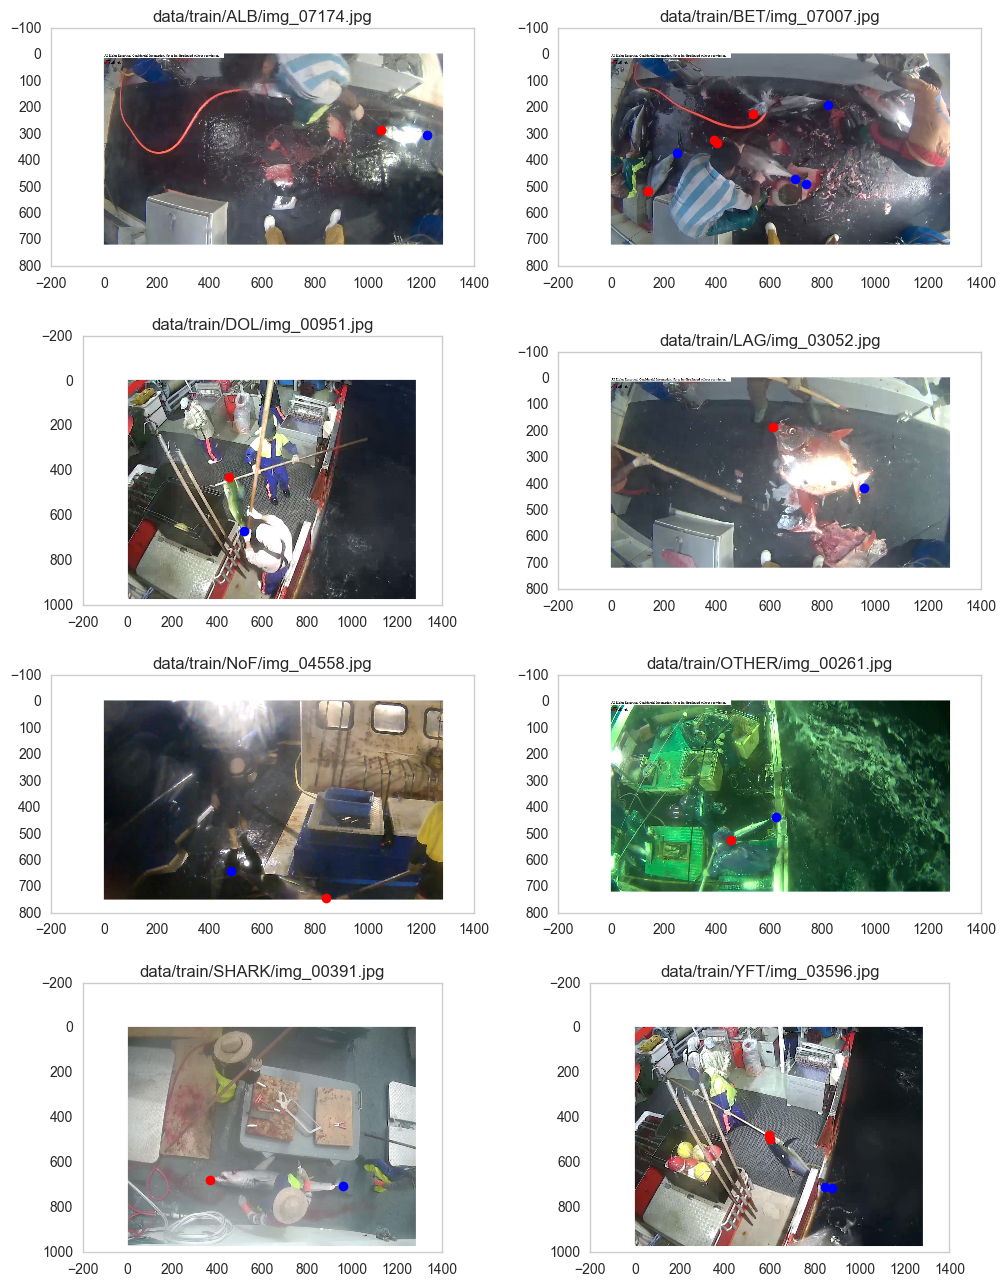

In [12]:
# sample an image per class of fish
fishes = df_full.groupby('category').apply(lambda x: x.sample(1))
f = plt.figure(figsize=(12,16))
for i in range(len(fishes)):
    # get image path
    fpath = fishes.iloc[i]['fpath']
    fname = fishes.iloc[i]['fname']
    img = io.imread(fpath)
    # get all annotations for that image
    anno = df_full.loc[df_full['fname']==fname,['head_x','head_y','tail_x','tail_y']]
    head_x, head_y, tail_x, tail_y = \
    np.array(anno['head_x'],dtype='int'), np.array(anno['head_y'],dtype='int'),\
    np.array(anno['tail_x'],dtype='int'), np.array(anno['tail_y'],dtype='int')
    ax = plt.subplot(4,2,i+1)
    ax.imshow(img)
    ax.set_title(fpath)
    ax.plot(head_x,head_y,'ro')
    ax.plot(tail_x,tail_y,'bo')



Before we start training our model, we need a few things:
 - Data Generator (train, valid, test, with augmentation)
 - Model Specification and weights (borrowed from [here](https://github.com/fchollet/deep-learning-models))

## Data Generator

Given the small amount of data provided, and the correlated nature of some of these images (from the same video camera on the same boat), we need to heavily augment the data provided to prevent our model from 'memorising' the extraneous features, such as the boat, fishermen, etc. We will use:
 - horizontal/vertical flips (TODO)
 - +-15% rotations
 - crops
 - chance of occluding the fish and switching the label to 'NoF'
 - chance of blurring the fish while preserving the label
 

(224, 224, 3) 0


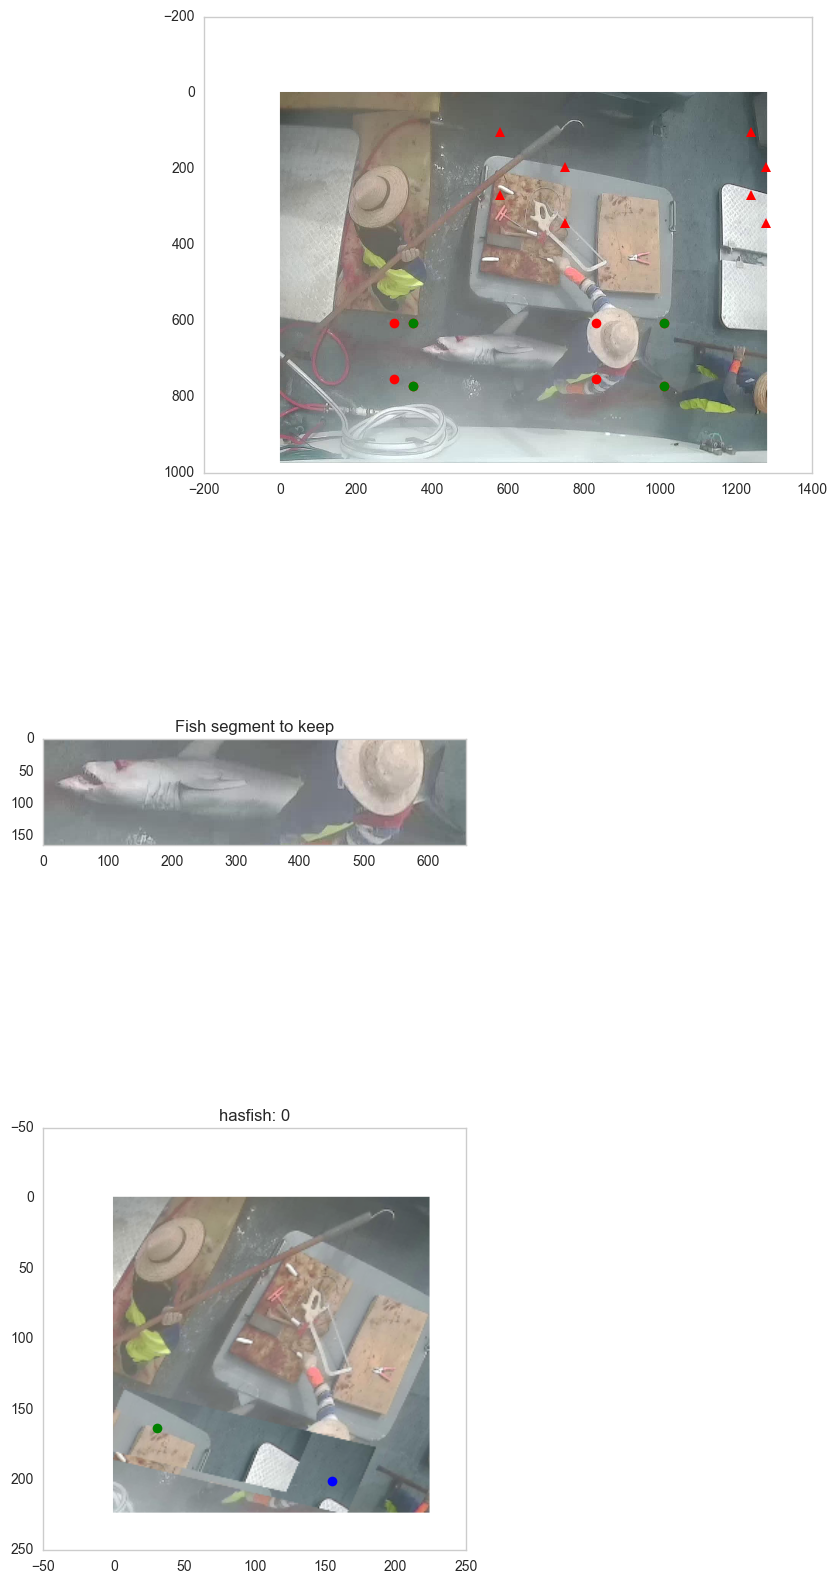

In [13]:
# helper functions

# takes a bounding box and checks if contains any of the annotated marks are inside
def contains(bbox,df_marks,bounding_buffer=30):
    x_min,x_max,y_min,y_max = bbox
    x_mins = df_marks.loc[:,['head_x','tail_x']].min(axis=1)
    x_maxs = df_marks.loc[:,['head_x','tail_x']].max(axis=1)
    y_mins = df_marks.loc[:,['head_y','tail_y']].min(axis=1)
    y_maxs = df_marks.loc[:,['head_y','tail_y']].max(axis=1)
    conds = ~((x_mins + bounding_buffer > x_min) & (x_maxs - bounding_buffer < x_max) \
              & (y_mins + bounding_buffer > y_min) & (y_maxs - bounding_buffer < y_max))
    return ~(conds.all())

# performs various distortions to the image and the corresponding annotated label, coords
def augment(df_marks,return_type,rng,p_remove=0.5,buffer_x_pct=0.15,buffer_y_pct=0.15,
           buffer_x_min=70,buffer_y_min=70,w_out=224,h_out=224,if_plot=False):
    fpath = df_marks['fpath'].iloc[0]
    img = io.imread(fpath)
    h_img, w_img, ch_img = img.shape
    if if_plot:
        f = plt.figure(figsize=(12,20))
        plt.subplot(311)
        plt.imshow(img)
    # get category (if a fish is present or not)
    category = df_marks.iloc[0]['category']
    hasfish = 0 if category=='NoF' else 1
    if hasfish:
        if rng.rand() < p_remove:
            # swap label, occlude all fish annotations with random part
            hasfish = 0
        # else keep 1 random fish annotation, and occlude all other fishes
        indices = rng.permutation(df_marks.index)
        i_keep = indices[0] # take the first amongst the shuffled fish indices
        for ix in indices:
            # get inner bounding box
            x_min = int(min(df_marks.loc[ix,'head_x'],df_marks.loc[ix,'tail_x']))
            x_max = int(max(df_marks.loc[ix,'head_x'],df_marks.loc[ix,'tail_x']))
            y_min = int(min(df_marks.loc[ix,'head_y'],df_marks.loc[ix,'tail_y']))
            y_max = int(max(df_marks.loc[ix,'head_y'],df_marks.loc[ix,'tail_y']))
            # expand bounding box
            h_box, w_box = y_max - y_min, x_max - x_min
            buffer_x = int(max(buffer_x_min,w_box * buffer_x_pct))
            buffer_y = int(max(buffer_y_min,h_box * buffer_y_pct))
            x_min = x_min - buffer_x if x_min > buffer_x else x_min
            y_min = y_min - buffer_y if y_min > buffer_y else y_min
            x_max = x_max + buffer_x if x_max + buffer_x < w_img else x_max
            y_max = y_max + buffer_y if y_max + buffer_y < h_img else y_max
            if if_plot:
                plt.plot(x_min,y_min,'ro')
                plt.plot(x_min,y_max,'ro')
                plt.plot(x_max,y_min,'ro')
                plt.plot(x_max,y_max,'ro')
            h_box, w_box = y_max - y_min, x_max - x_min
            assert(h_box > 0 and w_box > 0)
            # if keep, make a copy of the fish in the original position, store in keep
            if ix == i_keep:
                if if_plot:
                    plt.plot(x_min,y_min,'go')
                    plt.plot(x_min,y_max,'go')
                    plt.plot(x_max,y_min,'go')
                    plt.plot(x_max,y_max,'go')
                x_head = int(df_marks.loc[ix,'head_x'])
                x_tail = int(df_marks.loc[ix,'tail_x'])
                y_head = int(df_marks.loc[ix,'head_y'])
                y_tail = int(df_marks.loc[ix,'tail_y'])
                keep = img[y_min:y_max,x_min:x_max,:].copy()
                if if_plot:
                    plt.subplot(323)
                    plt.imshow(keep)
                    plt.title('Fish segment to keep')
                    plt.subplot(311)
                x_keep_min, y_keep_min = x_min, y_min
                h_keep, w_keep = h_box, w_box
            # get another random box of a similar size that doesn't contain a fish
            x_swap_min = int(rng.uniform(0,w_img-w_box,1))
            y_swap_min = int(rng.uniform(0,h_img-h_box,1))
            x_swap_max = x_swap_min + w_box
            y_swap_max = y_swap_min + h_box
            bbox = (x_swap_min,x_swap_max,y_swap_min,y_swap_max)
            while contains(bbox,df_marks):
                x_swap_min = int(rng.uniform(0,w_img-w_box,1))
                y_swap_min = int(rng.uniform(0,h_img-h_box,1))
                x_swap_max = x_swap_min + w_box
                y_swap_max = y_swap_min + h_box
                bbox = (x_swap_min,x_swap_max,y_swap_min,y_swap_max)
            if if_plot:
                plt.plot(x_swap_min,y_swap_min,'r^')
                plt.plot(x_swap_min,y_swap_min+h_box,'r^')
                plt.plot(x_swap_min+w_box,y_swap_min,'r^')
                plt.plot(x_swap_min+w_box,y_swap_min+h_box,'r^')
            # copy over random box
            random_box = img[y_swap_min:(y_swap_min+h_box),
                x_swap_min:(x_swap_min+w_box),:].copy()
            img[y_min:y_max,x_min:x_max,:] = random_box
        # put a fish back in a random position
        if hasfish:
            if if_plot:
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
            x_swap_min = int(rng.uniform(0,w_img-w_keep,1))
            y_swap_min = int(rng.uniform(0,h_img-h_keep,1))
            x_diff = x_swap_min - x_keep_min
            y_diff = y_swap_min - y_keep_min
            x_head = x_head + x_diff
            x_tail = x_tail + x_diff
            y_head = y_head + y_diff
            y_tail = y_tail + y_diff
            if if_plot:
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
                plt.plot(x_head,y_head,'yo')
                plt.plot(x_tail,y_tail,'yo')
            img[y_swap_min:(y_swap_min+h_keep), \
                x_swap_min:(x_swap_min+w_keep),:] = keep
            if if_plot:
                plt.subplot(324)
                plt.imshow(img)
                plt.plot(x_swap_min,y_swap_min,'bo')
                plt.plot(x_swap_min,y_swap_min+h_keep,'bo')
                plt.plot(x_swap_min+w_keep,y_swap_min,'bo')
                plt.plot(x_swap_min+w_keep,y_swap_min+h_keep,'bo')
            
    
    # perform affine transformations
    r_tx, r_ty = rng.normal(w_img/2,50,1)[0], rng.normal(h_img/2,50,1)[0]
    r_tx = 0 if r_tx < 0 else w_img if r_tx > w_img else int(r_tx)
    r_ty = 0 if r_ty < 0 else h_img if r_ty > h_img else int(r_ty)
    r_rotate = rng.uniform(-np.pi/6,np.pi/6,1)[0]
    tf_rotate = tf.SimilarityTransform(rotation=r_rotate)
    tf_scale = tf.SimilarityTransform(scale=rng.uniform(0.8,1.5,1))
    tf_shear = tf.AffineTransform(shear=rng.uniform(-0.5,0.5,1))
    tf_shift = tf.SimilarityTransform(translation=[-r_tx, -r_ty])
    tf_shift_inv = tf.SimilarityTransform(translation=[r_tx, r_ty])
    trans = tf_shift + tf_scale + tf_shear + tf_rotate + tf_shift_inv

    head = np.matmul(trans.params[:2,:],np.array([x_head,y_head,1]))
    tail = np.matmul(trans.params[:2,:],np.array([x_tail,y_tail,1]))
    img_warped = tf.warp(img, trans.inverse)
    img_final = tf.resize(img_warped,(h_out,w_out))
    # rescale coordinates to output shape
    head[0] = head[0] / w_img * w_out
    head[1] = head[1] / h_img * h_out
    tail[0] = tail[0] / w_img * w_out
    tail[1] = tail[1] / h_img * h_out
    
    if if_plot:
        plt.subplot(325)
        plt.title('hasfish: %d' % hasfish)
        plt.imshow(img_final)
        plt.plot(head[0],head[1],'go')
        plt.plot(tail[0],tail[1],'bo')
    
    if return_type == 'contain':
        return img_final, hasfish
    elif return_type == 'coord':
        return img_final, np.array([head[0],head[1],tail[0],tail[1]])
    else:
        print('Unexpected return type %s. Please specify "contain" or "coord".' % return_type)

fpath = df_full.fpath.sample(n=1).iloc[0]
fpath = 'data/train/SHARK/img_06410.jpg'
df_marks = df_full.loc[df_full['fpath']==fpath]
im,hasfish = augment(df_marks,'contain',np.random.RandomState(1),if_plot=True)
print(im.shape,hasfish)

In [14]:
# TODO add stratified sampling

def gen(df_gen, return_type='contain', batch_size=32, rng=None, hX=224, wX=224, chX=3):
    """
    This generator produces a batch of (X,y) for training a fish detector.
    Images are randomly augmented.
    
    Inputs:
    df_gen is a pandas dataframe containing the file path (fpath), 
    potentially multiple head and tail annotations
    return_type is string of either 'contain' or 'coord'
    
    Outputs:
    X is a 4D tensor of shape (batch_size,h,w,ch)
    y is a binary vector with 1 if the image has a fish else 0
    """
    if return_type not in ['contain','coord']:
        raise ValueError('Invalid return type %s' % return_type)
    if rng is None:
        rng = np.random.RandomState(241016)
    fishes = df_gen['fpath'].unique()
    n = len(fishes)
    total_batch = int(n / batch_size)
    while True:
        # shuffle examples every epoch
        fishes_shuffled = fishes[rng.permutation(n)]
        for i_batch in range(total_batch):
            # limit end index by size of df_gen to prevent 
            # indexing up to the next multiple of batch_size
            i_start, i_end = i_batch * batch_size, min((i_batch + 1) * batch_size,n)
            i_batch_size = i_end - i_start
            X = np.zeros((i_batch_size,hX,wX,chX))
            if return_type == 'contain':
                Y = np.zeros(i_batch_size)
            else:
                Y = np.zeros((i_batch_size,4))
            for i_fish in range(i_start,i_end):
                i_fpath = fishes_shuffled[i_fish]
                df_marks = df_gen.loc[df_gen['fpath']==i_fpath]
                x,y = augment(df_marks,return_type,rng) # augment image
                i_intrabatch = i_fish - i_start
                X[i_intrabatch,:] = x
                Y[i_intrabatch] = y
            logging.debug('yielding batch %d of size %d' % (i_batch, i_batch_size))
            yield (X,Y)

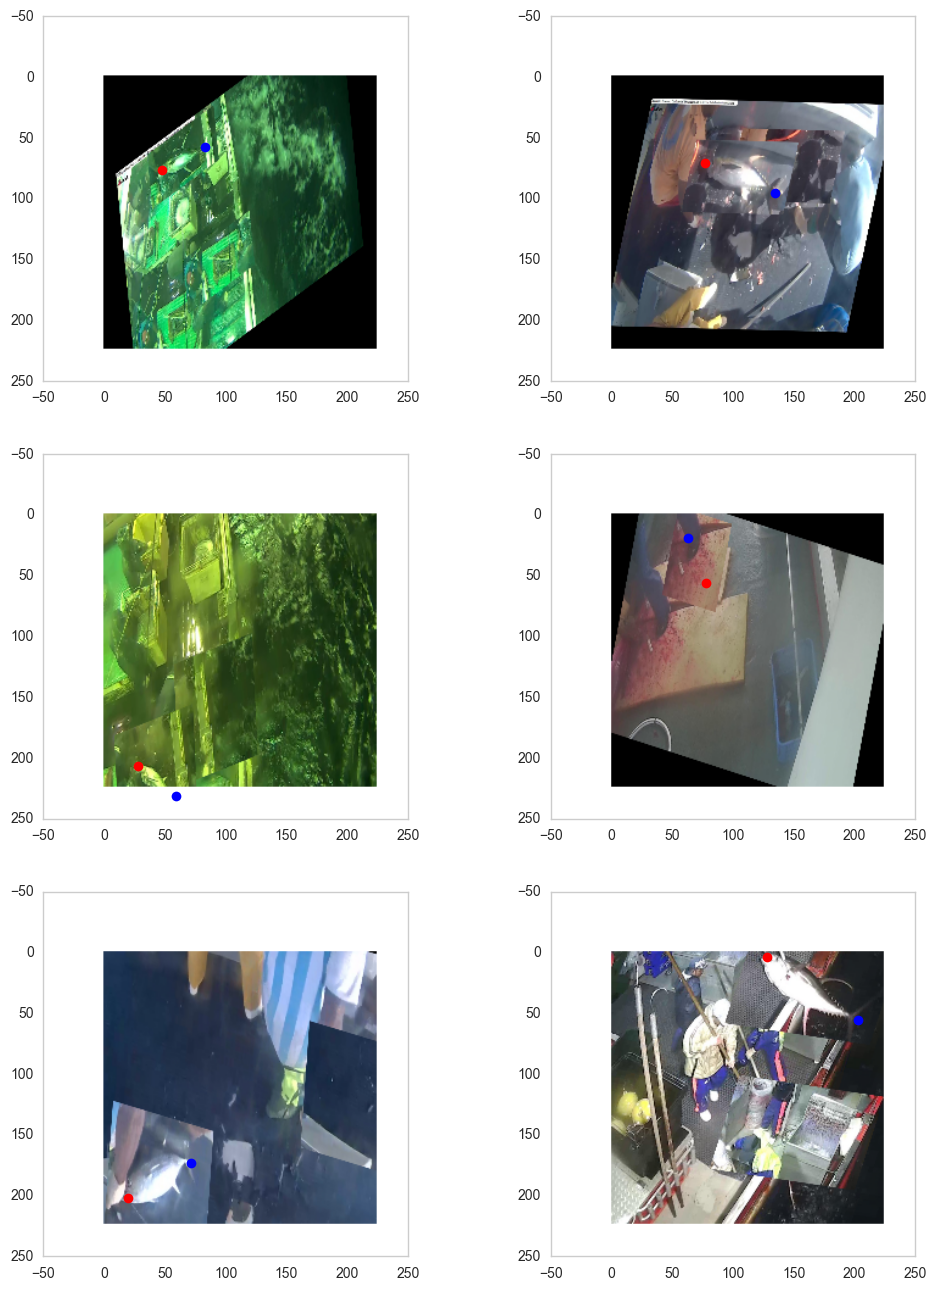

In [15]:
# visual test: generate a batch of 6 and print the plots
bs = 6
gen_train = gen(df_full,'coord',6,np.random.RandomState(123))
X,Y = next(gen_train)
plt.figure(figsize=(12,16))
for i in range(bs):
    plt.subplot('32'+str(i+1))
    plt.imshow(X[i,...])
    if len(Y.shape) > 1:
        plt.plot(Y[i,0],Y[i,1],'ro')
        plt.plot(Y[i,2],Y[i,3],'bo')
    else:
        plt.title(Y[i])


Having built a reliable generator for supplying a stream of augmented images that can produce both binary responses (1 if a fish is present) and real-valued coordinates, we move on to define a model that will consume these augmented images to predict the class of fish (as a first cut benchmark).

## Model Definition

TODO